# Reinforcement Learning Dev
With tensorflow:
- general PPO tutorial: https://pytorch.org/tutorials/intermediate/reinforcement_ppo.html
- RF Environment for stock trading: https://lixiaoguang.medium.com/create-custom-openai-gym-environment-for-deep-reinforcement-learning-drl-af2b2e3c830d
- RF training for stock trading: https://lixiaoguang.medium.com/training-dqn-models-for-trading-using-pytorch-and-stable-baselines3-ml4t-005-2c256373db7b


With keras:
https://github.com/bharatpurohit97/StockPrediction/blob/master/ReinforcementLearning-YahooFinance/Tutorial/Stock-Prediction.ipynb

Instal torchrl through
- pip install git+https://github.com/pytorch-labs/tensordict
- pip install git+https://github.com/pytorch/rl.git

In [1]:
import yfinance as yf
import pandas as pd
def get_data_from_yahoo(ticker: str = 'DAX', period_days: int = None, sampling_rate_min: int = None,
                        sampling_rate_days: int = 1, verbose=True, m_avg_days=[5, 30, 90],
                        m_avg_column='Close', validation_split=0.1,
                        start_date=None, end_date=None) -> pd.DataFrame:
    # download data:
    period = f'{period_days}d' if period_days is not None else 'max'
    interval = f'{sampling_rate_min}m' if sampling_rate_days is None else f'{sampling_rate_days}d'
    data = yf.download(tickers=ticker, period=period, interval=interval,
                       start=start_date, end=end_date, progress=verbose)

    # calculate data coverage subtracting weekends:
    if verbose:
        pandas_freq = f'{sampling_rate_days}D' if sampling_rate_days is not None else f'{sampling_rate_min}min'
        compare_dt_index = pd.date_range(start=data.index[0], end=data.index[-1], freq=pandas_freq)
        compare_dt_index = compare_dt_index[~compare_dt_index.weekday.isin([5, 6])]  # exclude weekends
        compare_dt_index = compare_dt_index[~ ((compare_dt_index.hour < data.index.hour.min()) | (
                    compare_dt_index.hour > data.index.hour.max()))]  # exclude non-operating hours
        print(
            f"Coverage of downloaded data: {round(len(data) / len(compare_dt_index) * 100, 1)}%! Weekends and non-operating hours excluded. Can be due to holidays or missing data.")
        data[m_avg_column].plot()


    # eventually calculate moving averages:
    if m_avg_days is not None:
        for days in m_avg_days:
            data[f"MA{days}"] = data[m_avg_column].rolling(window=f"{days}d").mean()

    # remove index:
    data.reset_index(inplace=True)

    # return with or without validation split:
    if validation_split is not None:
        if verbose: print(f"Returning last {100 * validation_split}% of data for validation. Other data for training.")
        validation_split_index = int(len(data) * (1-validation_split))
        return (data.iloc[:validation_split_index], data.iloc[validation_split_index:])
    else:
        return data

In [2]:
tickers = ['^GDAXI', '^IXIC', '^DJI', '^GSPC']
years_to_backtest = 5
data_tuples = [get_data_from_yahoo(ticker, period_days=int(365.25*years_to_backtest), verbose=False, validation_split=0.2) for ticker in tickers]


1 Failed download:
['^GDAXI']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['^IXIC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['^DJI']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [6]:
# split into dicts:
train_dict = {tickers[ind]: data_tuples[ind][0] for ind in range(len(tickers))}
test_dict = {tickers[ind]: data_tuples[ind][1] for ind in range(len(tickers))}

## 1. RL Environment Dev
OpenAI Gym is a **popular toolkit for developing reinforcement learning algorithms**. It provides a **collection of environments** that simulate different scenarios for agents to learn in.

In [7]:
import gym
from gym import spaces
import numpy as np
import random
import enum

An environment provides methods for **action**, **observation** and **rewards**.

In [10]:
class TradingActions(enum.Enum):
    """ Actions for trading. Buy or sell all. No amount possible. """
    Hold = 0
    Buy = 1
    Sell = 2

class RLTradingEnv(gym.Env):
    """ A trading environment for OpenAI gym """
    metadata = {'render.modes': ['human']}

    def __init__(self,
                 data_frame_dict: dict,
                 price_column='Close',
                 indicator_columns=['MA5', 'MA30', 'MA90'],
                 starting_cash=100000,
                 commission_rate=0,
                 sample_days=30,
                 random_on_reset=True,
                 verbose=True
                 ):
        """
        Represents the initialization method for the RLTradingEnv class, where key
        parameters related to the trading environment such as data frames, pricing
        information, initial cash balance, commission rate, and sampling days
        are set upon instantiation.

        :param data_frame_dict: A dictionary where keys represent identifiers for
            trading instruments or assets, and values are Pandas DataFrames
            containing time-series market data for each respective instrument.
            Each episode, one stock is trained.
        :param price_column: Name of the column in the DataFrame that contains
            the price information. This is typically the closing price of the
            instrument.
        :param indicator_columns: Names of the columns in the DataFrame that contain
            metrics for agent to base his decision on
        :param starting_cash: The initial amount of cash available in the environment
            for trading (at beginning of every episode).
        :param commission_rate: The commission or transaction fee rate applied to
            each trade. Represented as a decimal value, where 0.01 corresponds to
            a 1% transaction cost.
        :param sample_days: Number of previous days that are observable to the agent in each episode.
        :param random_on_reset: whether each episode randomly selects a stock to train
        """
        super(RLTradingEnv, self).__init__()  # initialise base class
        self.data_frame_dict = data_frame_dict
        self.price_column = price_column

        # moving average days to be calculated:
        self.indicator_columns = indicator_columns
        self.starting_cash = starting_cash
        self.commission_rate = commission_rate
        self.sample_days = sample_days
        self.random_on_reset = random_on_reset
        self.verbose = verbose

        # current episode (sequence of steps)
        self.cur_episode = self.next_episode() if random_on_reset else 0

        # current step (status and actions)
        self.cur_step = self.sample_days

        # set of possible actions as discrete values:
        self.action_space = spaces.Discrete(len(TradingActions))

        # set of floats representing available information for agent:
        self.observation_space = spaces.Box(low=-np.inf,
                                            high=np.inf,
                                            shape=(len(self.indicator_columns) * self.sample_days + 3,),
                                            dtype=np.float16)
        # contains indicator columns and three more for (cash, price and action)

        # possible range of rewards for actions:
        self.reward_range = (-np.inf, np.inf)

        # initial conditions:
        self.cash = self.starting_cash
        self.shares = 0

    def step(self, action):
        """
        Execute an action, return the reward and move to the next status.
        Takes action.
        Returns observation (box), reward (float), done (bool, indicating whether episode is finished) and info (dict).
        """
        # infer current balance:
        balance = self.cur_balance

        # increase step and check if episode is finished (adjust cur_step and cur_episode)
        self.cur_step += 1
        if self.cur_step == self.total_steps:
            self.cur_episode = self.next_episode()
            self.cur_step = self.sample_days

        # take action:
        self.take_action(action)

        # compute status and calculate reward:
        obs = self.next_observation(action)
        reward = self.cur_balance - balance  # equals change of balance
        done = self.cur_step == self.total_steps - 1  # see if episode is finished

        # construct info dictionary:
        info = { 'Step'  : self.cur_step,
                 'Reward' : round(reward, 2),
                 'Symbol' : self.cur_symbol,
                 'Action' : TradingActions(action).name,
                 'Shares' : self.shares,
                 'Close'  : round(self.cur_close_price, 2),
                 'Cash'   : round(self.cash, 2),
                 'Total'  : round(self.cur_balance, 2) }

        # if done: self.reset()  # happens automatically!

        return obs, reward, done, info

    def take_action(self, action):
        """ Takes action and updates current balance. Hold has no implication. """
        if action == TradingActions.Buy.value:  # buy all:
            if self.shares == 0:  # only if no shares held:
                price = self.cur_close_price * (1 + self.commission_rate)
                self.shares = int(self.cash / price)
                self.cash -= self.shares * price
                if self.verbose:
                    print(f"[STEP {self.cur_step}] Bought {self.cur_symbol} at {self.cur_close_price}")
                    print(f"    Cash: {self.cash}, Shares: {self.shares}")
        elif action == TradingActions.Sell.value:  # sell all:
            if self.shares > 0:  # only if there are shares to sell:
                price = self.cur_close_price * (1 - self.commission_rate)
                self.cash += self.shares * price
                self.shares = 0
                if self.verbose:
                    print(f"[STEP {self.cur_step}] Sold {self.cur_symbol} at {self.cur_close_price}")
                    print(f"    Cash: {self.cash}, Shares: {self.shares}")

    def next_observation(self, action):
        """ Construct and return new observable status. Reads current indicators (for sample_days), cash, balance and action. """
        observation = np.array([], dtype=np.int64)
        for i in range(self.sample_days, 0, -1):
            observation = np.append(observation, list(self.cur_indicators.iloc[self.cur_step - i + 1, :]))
        return np.append(observation, [self.cash, self.shares * self.cur_close_price, action])

    def next_episode(self):
        """ Select stock to be trained at beginning of episode. """
        if self.random_on_reset:
            return random.randrange(0, self.total_episodes)
        else:
            return (self.cur_episode + 1) % self.total_episodes

    def reset(self):
        """ Initialises environment when starting new episode. Returns next status. """
        if self.verbose:  # info statement
            print(f"Starting episode {self.cur_episode + 1}", (f"/{self.total_episodes}" if not self.random_on_reset else ""))
        self.cash = self.starting_cash
        self.shares = 0
        return self.next_observation(TradingActions.Hold.value)

    ################ properties ################
    @property
    def total_episodes(self):
        """ Total episodes equals amount of provided stock data frames. """
        return len(self.data_frame_dict)

    @property
    def cur_symbol(self):
        """ Current symbol is the key of the current episode's data frame. """
        return list(self.data_frame_dict.keys())[self.cur_episode]

    @property
    def cur_data(self):
        """ Current data is the current episode's data frame. '"""
        return self.data_frame_dict[self.cur_symbol]

    @property
    def cur_indicators(self):
        """ Current indicators are the technical indicators in the current data. """
        return self.cur_data[self.indicator_columns]

    @property
    def total_steps(self):
        """ Total steps equals length of current stock data frame."""
        return len(self.cur_data)

    @property
    def cur_close_price(self):
        """ Current close price is the price of the current symbol at current time. """
        return self.cur_data[self.price_column].iloc[self.cur_step].item()

    @property
    def cur_balance(self):
        """ Current balance equals cash plus current shares times current price. """
        return self.cash + (self.shares * self.cur_close_price)

In [11]:
env = RLTradingEnv(train_dict, sample_days=30, random_on_reset=True, verbose=False)

## 2. RL Training
With stable-baseline3 and pytorch.

Stable-Baselines3 is a reinforcement learning library built on top of PyTorch. It provides a set of pre-implemented RL algorithms and simplifies the process of training and evaluating RL models. It also includes a variety of useful tools for monitoring training progress and visualizing model behavior.

For training we will use Deep Q-Network (DQN). DQN is a reinforcement learning algorithm that uses a deep neural network to approximate the Q-value function. The Q-value function is a function that receives a status-action pair and outputs a value representing the expected cumulative reward for taking that action from that status, and continues playing following the optimal policy.

In [12]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN

See https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html

In [13]:
# MlpPolicy is policy used for training
# DummyVecEnc optimizes training through multiple independent variables
model = DQN('MlpPolicy', DummyVecEnv([lambda: env]), learning_rate=0.001, verbose=1)

/Users/paulrusing/miniconda3/envs/rl_env/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


Train model:

In [ ]:
model.learn(total_timesteps=50000, log_interval=100, progress_bar=True)

In [15]:
model.save('saved_rl_trading_model.pt')

## 3. RL Run

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# model = DQN.load('saved_rl_trading_model.pt')

In [17]:
logs = []  # list of log frames
for symbol, data in test_dict.items():  # iterate over stock data:
    env = RLTradingEnv({ symbol: data }, random_on_reset=False)
    model.set_env(DummyVecEnv([lambda: env]))

    obs = env.reset()
    done = False

    log = pd.DataFrame()
    while(not done):
        action, _ = model.predict(obs)
        obs, _, done, info = env.step(action)
        log = pd.concat([log, pd.DataFrame(info, index=[info['Step']])])
    logs.append(log)

/Users/paulrusing/miniconda3/envs/rl_env/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Starting episode 1 /1
[STEP 71] Buying ^GDAXI at 16404.759765625
    Cash: 100000, Shares: 0
[STEP 107] Selling ^GDAXI at 16961.390625
    Cash: 1571.44140625, Shares: 6
[STEP 114] Buying ^GDAXI at 17033.240234375
    Cash: 103339.78515625, Shares: 0
[STEP 131] Selling ^GDAXI at 17678.189453125
    Cash: 1140.34375, Shares: 6
[STEP 186] Buying ^GDAXI at 18726.759765625
    Cash: 107209.48046875, Shares: 0
[STEP 193] Selling ^GDAXI at 18496.7890625
    Cash: 13575.681640625, Shares: 5
[STEP 261] Buying ^GDAXI at 18747.109375
    Cash: 106059.626953125, Shares: 0
[STEP 264] Selling ^GDAXI at 18301.900390625
    Cash: 12324.080078125, Shares: 5
[STEP 291] Buying ^GDAXI at 19486.189453125
    Cash: 103833.58203125, Shares: 0


/Users/paulrusing/miniconda3/envs/rl_env/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Starting episode 1 /1
[STEP 45] Buying ^IXIC at 13186.1796875
    Cash: 100000, Shares: 0
[STEP 55] Selling ^IXIC at 13294.1904296875
    Cash: 7696.7421875, Shares: 7
[STEP 106] Buying ^IXIC at 15055.650390625
    Cash: 100756.0751953125, Shares: 0
[STEP 177] Selling ^IXIC at 15657.8203125
    Cash: 10422.1728515625, Shares: 6
[STEP 195] Buying ^IXIC at 16920.7890625
    Cash: 104369.0947265625, Shares: 0
[STEP 229] Selling ^IXIC at 18509.33984375
    Cash: 2844.3603515625, Shares: 6
[STEP 252] Buying ^IXIC at 17631.720703125
    Cash: 113900.3994140625, Shares: 0
[STEP 272] Selling ^IXIC at 17592.130859375
    Cash: 8110.0751953125, Shares: 6
[STEP 273] Buying ^IXIC at 17628.060546875
    Cash: 113662.8603515625, Shares: 0
[STEP 282] Selling ^IXIC at 18189.169921875
    Cash: 7894.4970703125, Shares: 6


/Users/paulrusing/miniconda3/envs/rl_env/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Starting episode 1 /1
[STEP 40] Buying ^DJI at 33631.140625
    Cash: 100000, Shares: 0
[STEP 94] Selling ^DJI at 37689.5390625
    Cash: 32737.71875, Shares: 2
[STEP 102] Buying ^DJI at 37711.01953125
    Cash: 108116.796875, Shares: 0
[STEP 117] Selling ^DJI at 38654.421875
    Cash: 32694.7578125, Shares: 2
[STEP 160] Buying ^DJI at 38904.0390625
    Cash: 110003.6015625, Shares: 0
[STEP 206] Selling ^DJI at 38747.421875
    Cash: 32195.5234375, Shares: 2


/Users/paulrusing/miniconda3/envs/rl_env/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Starting episode 1 /1
[STEP 145] Buying ^GSPC at 5150.47998046875
    Cash: 100000, Shares: 0
[STEP 192] Selling ^GSPC at 5321.41015625
    Cash: 2140.88037109375, Shares: 19
[STEP 301] Buying ^GSPC at 5808.1201171875
    Cash: 103247.67333984375, Shares: 0


Compare results against benchmark (buy and hold from day one):

In [18]:
val = pd.DataFrame()
for log in logs:
    log['Benchmark'] = env.starting_cash / log['Close'].iloc[0] * log['Close']
    log['Policy'] = log['Total']
    val = val.add(log[['Benchmark', 'Policy']], fill_value=0)
val

,Benchmark,Policy
31,400000.000000,400000.00
32,402408.454164,400000.00
33,398110.642111,400000.00
34,400394.310889,400000.00
35,398536.791222,400000.00
...,...,...
361,567473.404178,448506.15
362,562997.120001,448028.56
363,568254.005101,449419.05
364,566766.651894,449200.52


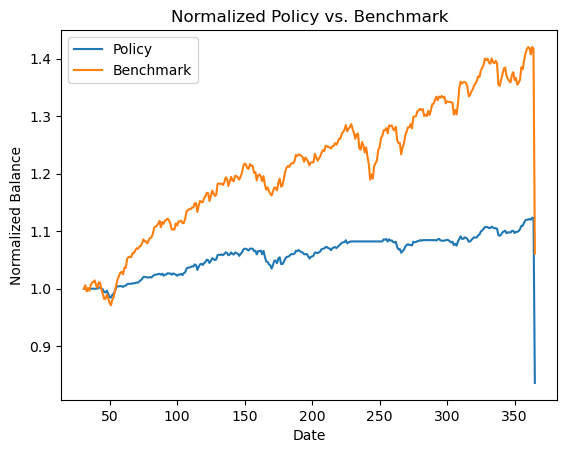

In [19]:
val['Policy'] /= val['Benchmark'].iloc[0]
val['Benchmark'] /= val['Benchmark'].iloc[0]

ax = val[['Policy', 'Benchmark']].plot(title='Normalized Policy vs. Benchmark')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Balance')
plt.show()